In [1]:
import lmdb
import os
import matplotlib.pyplot as plt
import numpy as np
import zlib
def show_img(img):
    plt.close()
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.show()

In [2]:
"""
key format:
# first part is position index the second is orientation index 
each frame has 3 keys:
    0000_01_rgb    : 512,512,3 dtype uint8
    0000_01_depth  : 512,512 dtype uint16 depth in mm zero means no depth
    0000_01_pose   : 4x4 float32 c2w matrix
"""

'\nkey format:\n# first part is position index the second is orientation index \neach frame has 3 keys:\n    0000_01_rgb    : 512,512,3 dtype uint8\n    0000_01_depth  : 512,512 dtype uint16 depth in mm zero means no depth\n    0000_01_pose   : 4x4 float32 c2w matrix\n'

# load random pose

In [3]:
folder = "/work/vig/hieu/3dfront_data/images_renderings"
folder = "/mnt/Data/hieu/BlenderProc-3DFront/examples/datasets/front_3d_with_improved_mat/images_renderings"
scene_id = "6a0e73bc-d0c4-4a38-bfb6-e083ce05ebe9"
env = lmdb.open(
    os.path.join(folder, scene_id),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
)
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    exist_keys = [key.decode().split('_')[0] for key in exist_keys]

In [4]:
len(set(exist_keys))

53

In [6]:
250/630*6000000

2380952.3809523806

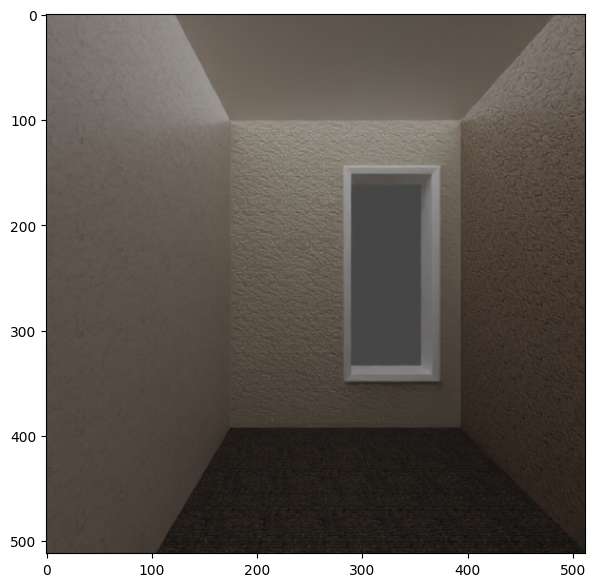

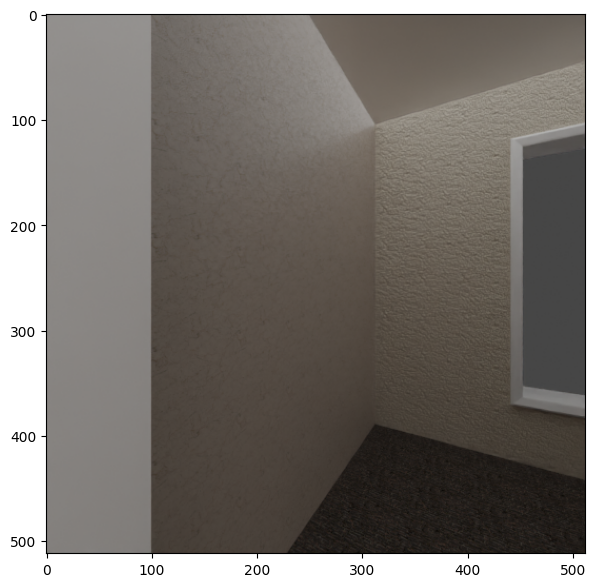

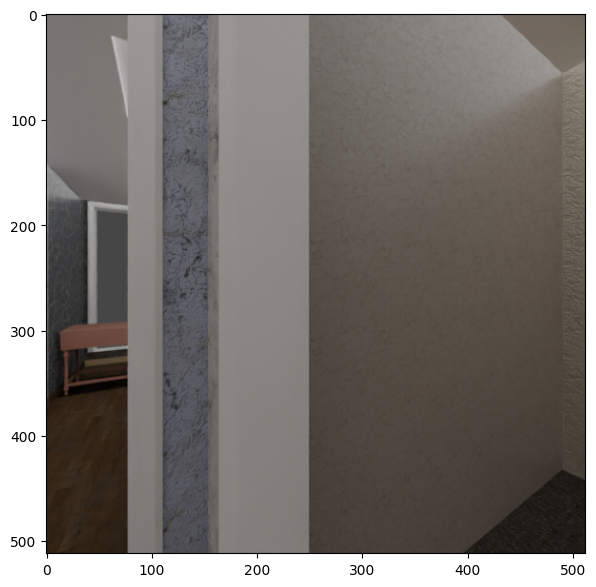

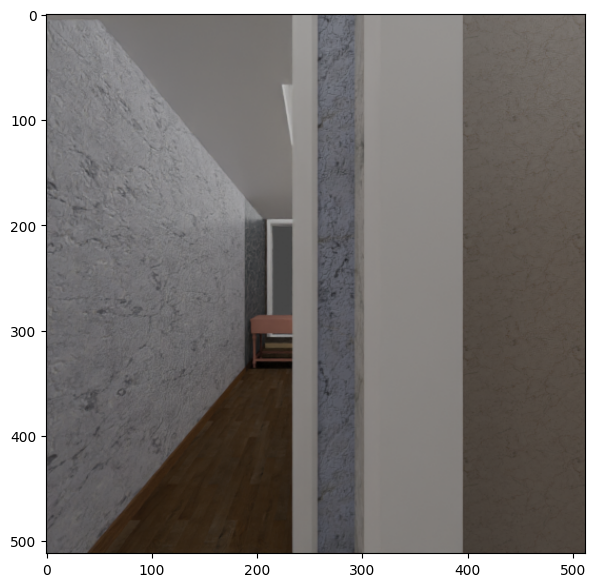

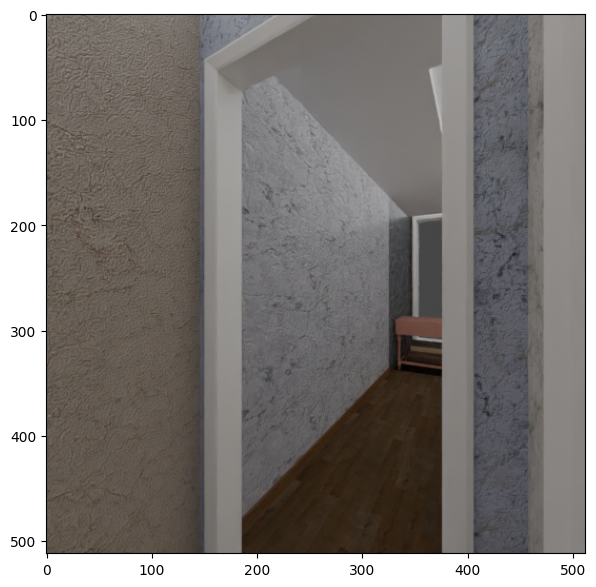

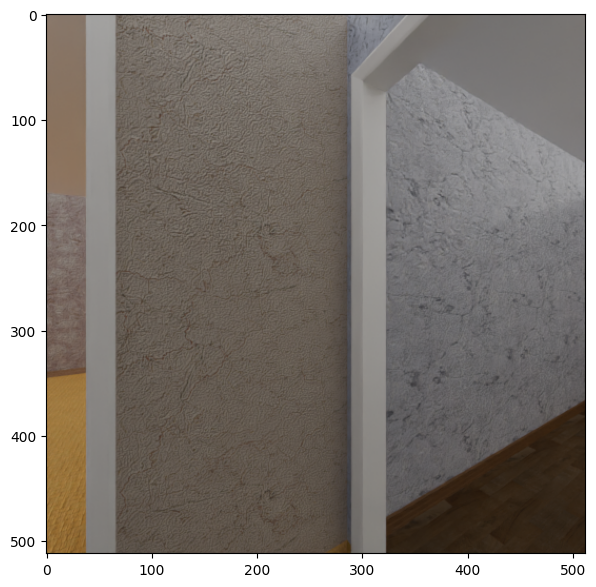

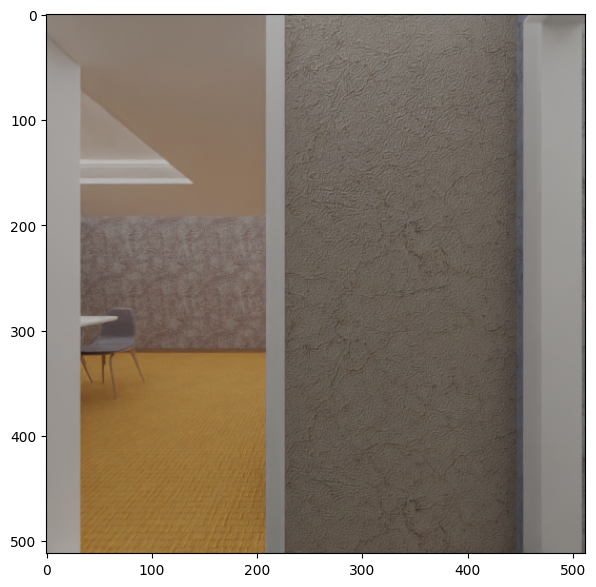

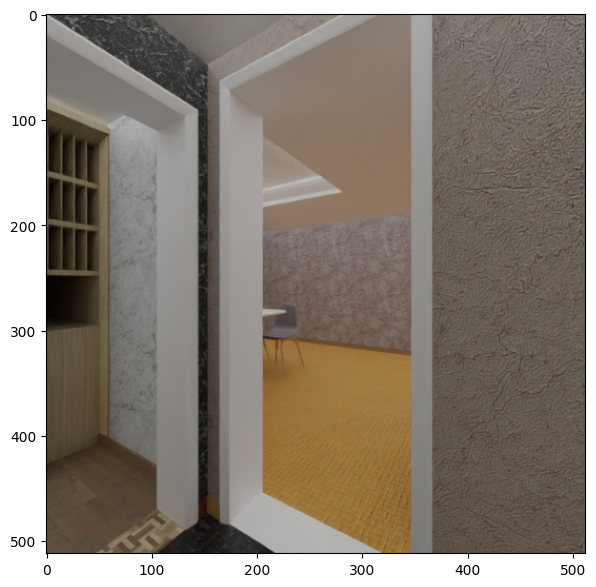

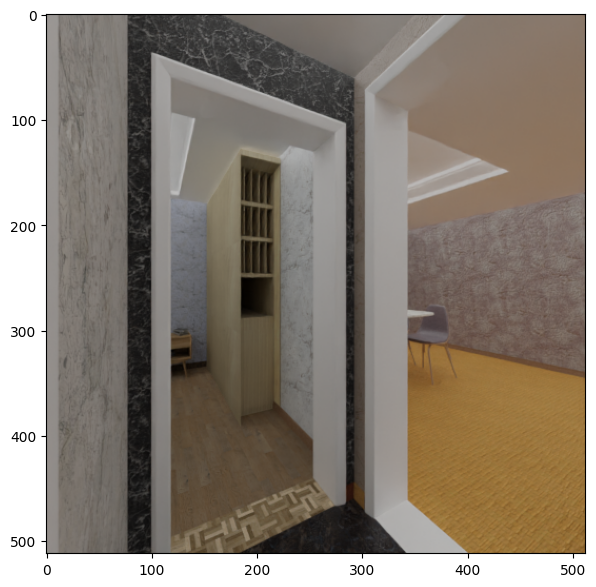

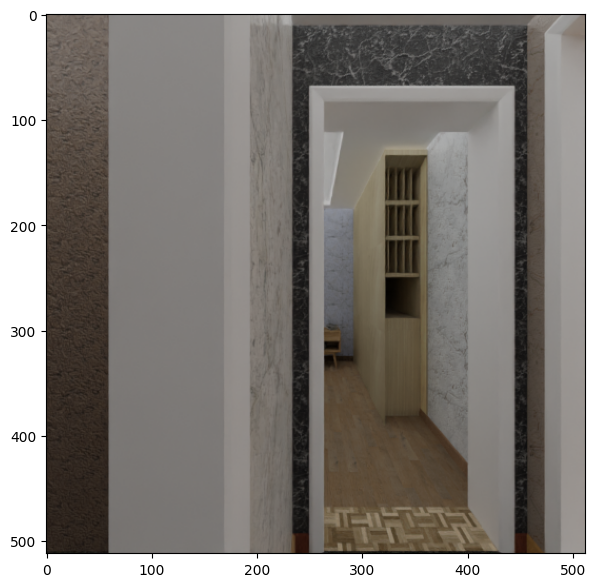

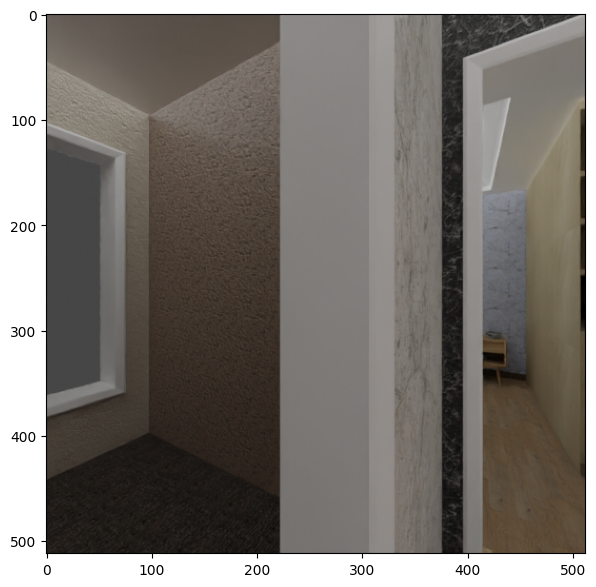

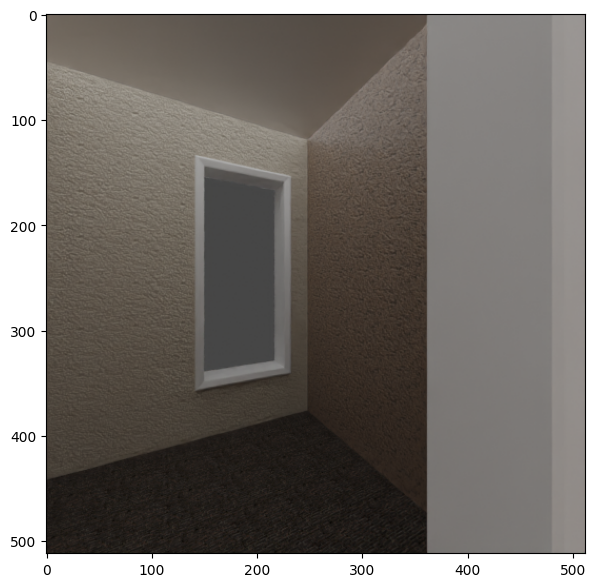

In [7]:
for i in range(12):
    key = f"0002_{i:0>2}_rgb".encode("ascii")
    txn = env.begin()
    img = zlib.decompress(txn.get(key))
    img = np.frombuffer(img, dtype=np.uint8).reshape(512, 512, 3)
    show_img(img)

In [ ]:
for i in range(12):
    key = f"0000_{i:0>2}_depth".encode("ascii")
    txn = env.begin()
    depth = zlib.decompress(txn.get(key))
    depth = np.frombuffer(depth, dtype=np.uint16).reshape(512, 512)
    show_img(depth)

In [4]:
i = 0
key = f"0000_{i:0>2}_pose".encode("ascii")
txn = env.begin()
pose = zlib.decompress(txn.get(key))
pose = np.frombuffer(pose, dtype=np.float32).reshape(4, 4)
pose

array([[ 1.       ,  0.       ,  0.       , -1.1162988],
       [ 0.       ,  1.       ,  0.       ,  1.5184809],
       [ 0.       ,  0.       ,  1.       , -0.6253474],
       [ 0.       ,  0.       ,  0.       ,  1.       ]], dtype=float32)

# pano in the floor

In [22]:
# image_dir = "/media/hieu/T7/3dfront_test_floor0.7_livingroom_png"
image_dir = "/media/hieu/T7/3dfront_test_floor0.7_secondbedroom_png"
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    exist_keys = [key.decode() for key in exist_keys]
    # exist_keys = [key for key in exist_keys if "rgb" in key]
    # for key in exist_keys:
    #     img = txn.get(key.encode("ascii"))
    #     img = zlib.decompress(img)
    #     img = np.frombuffer(img, dtype=np.uint8).reshape(512, 512, 3)
    #     plt.imsave(os.path.join(image_dir, key + ".jpg"), img)

In [2]:
import cv2
folder = "/mnt/Data/hieu/BlenderProc-3DFront/examples/datasets/front_3d_with_improved_mat/images_bed_rendering"
folder = "/media/hieu/T7/3dfront_render/debug_obj"
scene_id = "6a0e73bc-d0c4-4a38-bfb6-e083ce05ebe9"
scene_id = "00ecd5d3-d369-459f-8300-38fc159823dc"
env = lmdb.open(
    os.path.join(folder, scene_id),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
)
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    # exist_keys = [key.decode().split('_')[0] for key in exist_keys]
    exist_keys = [key.decode() for key in exist_keys]

In [3]:
len(exist_keys)

534

In [42]:
exist_keys[:4]

['0001_00_depth', '0001_00_pose', '0001_00_rgb', '0001_01_depth']

In [4]:
image_dir = "/media/hieu/T7/3dfront_test_floor0.5_secondbedroom_floor_png"
image_dir = "/media/hieu/T7/debug_obj_png"
os.makedirs(image_dir, exist_ok=True)
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    exist_keys = [key.decode() for key in exist_keys]
    exist_keys = [key for key in exist_keys if "rgb" in key]
    for key in exist_keys:
        img = txn.get(key.encode("ascii"))
        img = np.frombuffer(img, dtype=np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        # img = np.frombuffer(img, dtype=np.uint8).reshape(512, 512, 3)
        plt.imsave(os.path.join(image_dir, key + ".jpg"), img)

In [47]:
# from colmap to blender
import quaternion as qt
BASE = np.array([
    [1.0, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
output_file = "images.txt"
os.remove(output_file)
image_dir = "/media/hieu/T7/3dfront_test_floor0.5_secondbedroom_floor_png"

def make_lines(i, q, t, name):
    return f"{i} {q.w} {q.x} {q.y} {q.z} {t[0]} {t[1]} {t[2]} 1 {name}"
img_files = os.listdir(image_dir)
print(img_files[:3])
with env.begin() as txn:
    for i, img_file in enumerate(img_files):
        print(img_file)
        key = img_file.split('.')[0]
        key = key[:-4] + "_pose"
        print(key)
        pose = txn.get(key.encode("ascii"))
        pose = np.frombuffer(zlib.decompress(pose), dtype=np.float32).reshape(4, 4)
        R = pose[:3, :3]@BASE
        T = pose[:3, 3]
        c2w = np.eye(4)
        c2w[:3, :3] = R
        c2w[:3, 3] = T
        w2c = np.linalg.inv(c2w)
        q = qt.from_rotation_matrix(w2c[:3, :3])
        t = w2c[:3, 3]
        print(make_lines(i+1, q, t, img_file), file=open(output_file, "a"))
        print(file=open(output_file, "a"))

['0001_00_rgb.jpg', '0001_01_rgb.jpg', '0001_02_rgb.jpg']
0001_00_rgb.jpg
0001_00_pose
0001_01_rgb.jpg
0001_01_pose
0001_02_rgb.jpg
0001_02_pose
0001_03_rgb.jpg
0001_03_pose
0001_04_rgb.jpg
0001_04_pose
0001_05_rgb.jpg
0001_05_pose
0001_06_rgb.jpg
0001_06_pose
0001_07_rgb.jpg
0001_07_pose
0001_08_rgb.jpg
0001_08_pose
0001_09_rgb.jpg
0001_09_pose
0001_10_rgb.jpg
0001_10_pose
0001_11_rgb.jpg
0001_11_pose
0002_00_rgb.jpg
0002_00_pose
0002_01_rgb.jpg
0002_01_pose
0002_02_rgb.jpg
0002_02_pose
0002_03_rgb.jpg
0002_03_pose
0002_04_rgb.jpg
0002_04_pose
0002_05_rgb.jpg
0002_05_pose
0002_06_rgb.jpg
0002_06_pose
0002_07_rgb.jpg
0002_07_pose
0002_08_rgb.jpg
0002_08_pose
0002_09_rgb.jpg
0002_09_pose
0002_10_rgb.jpg
0002_10_pose
0002_11_rgb.jpg
0002_11_pose
0003_00_rgb.jpg
0003_00_pose
0003_01_rgb.jpg
0003_01_pose
0003_02_rgb.jpg
0003_02_pose
0003_03_rgb.jpg
0003_03_pose
0003_04_rgb.jpg
0003_04_pose
0003_05_rgb.jpg
0003_05_pose
0003_06_rgb.jpg
0003_06_pose
0003_07_rgb.jpg
0003_07_pose
0003_08_rgb.jp

# random pose on the floor

In [15]:
import cv2
folder = "/media/hieu/T7/3dfront_render/secondbed_render_from_pose_015"
scene_id = "6a0e73bc-d0c4-4a38-bfb6-e083ce05ebe9"
env = lmdb.open(
    os.path.join(folder, scene_id),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
)
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    # exist_keys = [key.decode().split('_')[0] for key in exist_keys]
    exist_keys = [key.decode() for key in exist_keys]
img_keys = [key for key in exist_keys if "rgb" in key]

In [16]:
len(exist_keys)/3

155.0

In [17]:
image_dir = "/media/hieu/T7/3dfront_recon/secondbed_render_from_pose_015/png"
os.makedirs(image_dir, exist_ok=True)
with env.begin() as txn:
    for key in img_keys:
        # key = img_keys[i]
        img = txn.get(key.encode("ascii"))
        img = np.frombuffer(img, dtype=np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        plt.imsave(os.path.join(image_dir, key + ".jpg"), img)
        # plt.imshow(img)
        # plt.show()

In [19]:
### preset camera pose

# from colmap to blender
import quaternion as qt
BASE = np.array([
    [1.0, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
output_file = "/media/hieu/T7/3dfront_recon/secondbed_render_from_pose_015/colmap_pose/model/images.txt"
os.makedirs(os.path.dirname(output_file), exist_ok=True)
if os.path.exists(output_file): 
    os.remove(output_file)

def make_lines(i, q, t, name):
    return f"{i} {q.w} {q.x} {q.y} {q.z} {t[0]} {t[1]} {t[2]} 1 {name}"
img_files = os.listdir(image_dir)
print(img_files[:3])
with env.begin() as txn:
    for i, img_file in enumerate(img_files):
        key = img_file.split('.')[0]
        key = key[:-4] + "_pose"
        pose = txn.get(key.encode("ascii"))
        pose = np.frombuffer(zlib.decompress(pose), dtype=np.float32).reshape(4, 4)
        R = pose[:3, :3]@BASE
        T = pose[:3, 3]
        c2w = np.eye(4)
        c2w[:3, :3] = R
        c2w[:3, 3] = T
        w2c = np.linalg.inv(c2w)
        q = qt.from_rotation_matrix(w2c[:3, :3])
        t = w2c[:3, 3]
        print(make_lines(i+1, q, t, img_file), file=open(output_file, "a"))
        print(file=open(output_file, "a"))

['0000_rgb.jpg', '0002_rgb.jpg', '0003_rgb.jpg']


In [21]:
# make empty points3d.txt file
# make camera.txt file

os.system(f"touch {output_file.replace('images.txt', 'points3D.txt')}")
os.system(f"cp /media/hieu/T7/3dfront_recon/3dfront_test_floor0.5_secondbedroom_floor/3dfront_test_floor0.5_secondbedroom_floor_png_colmap_pose/model/cameras.txt {output_file.replace('images.txt', 'cameras.txt')}")
workdir = "/media/hieu/T7/3dfront_recon/secondbed_render_from_pose_015/colmap_pose"
extractor_cmd = f"colmap feature_extractor --database_path {workdir}/database.db --image_path {image_dir}"
matching_cmd = f"colmap exhaustive_matcher --database_path {workdir}/database.db"
os.system(extractor_cmd)
os.system(matching_cmd)
os.makedirs(os.path.join(workdir, "sparse", "0"), exist_ok=True)
triangulate_cmd = f"colmap point_triangulator --database_path {workdir}/database.db --image_path {image_dir} --input_path {workdir}/model --output_path {workdir}/sparse/0"
os.system(triangulate_cmd)
"""
    colmap feature_extractor \
    --database_path ./database.db \
    --image_path /media/hieu/T7/3dfront_recon/secondbed_render_from_pose/png
    
    colmap exhaustive_matcher --database_path ./database.db
    
colmap point_triangulator \
--database_path ./database.db \
--image_path /media/hieu/T7/3dfront_recon/secondbed_render_from_pose/png \
--input_path ./model \
--output_path ./sparse
"""
print()

I0403 15:21:02.806511 30946 misc.cc:198] 
Feature extraction
I0403 15:21:02.870465 30980 feature_extraction.cc:254] Processed file [1/155]
I0403 15:21:02.870481 30980 feature_extraction.cc:257]   Name:            0000_rgb.jpg
I0403 15:21:02.870482 30980 feature_extraction.cc:283]   Dimensions:      512 x 512
I0403 15:21:02.870484 30980 feature_extraction.cc:286]   Camera:          #1 - SIMPLE_RADIAL
I0403 15:21:02.870486 30980 feature_extraction.cc:289]   Focal Length:    614.40px
I0403 15:21:02.870491 30980 feature_extraction.cc:302]   Features:        1364
I0403 15:21:02.878831 30980 feature_extraction.cc:254] Processed file [2/155]
I0403 15:21:02.878841 30980 feature_extraction.cc:257]   Name:            0002_rgb.jpg
I0403 15:21:02.878844 30980 feature_extraction.cc:283]   Dimensions:      512 x 512
I0403 15:21:02.878845 30980 feature_extraction.cc:286]   Camera:          #2 - SIMPLE_RADIAL
I0403 15:21:02.878846 30980 feature_extraction.cc:289]   Focal Length:    614.40px
I0403 15:2

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.713671e+04    0.00e+00    1.28e+04   0.00e+00   0.00e+00  1.00e+04        0    7.02e-03    1.11e-02
   1  2.908578e+04    8.05e+03    6.38e+02   7.15e+00   9.92e-01  3.00e+04        0    8.03e-03    1.92e-02
   2  2.903123e+04    5.46e+01    7.29e+01   4.58e+00   9.63e-01  9.00e+04        0    7.03e-03    2.62e-02
   3  2.902937e+04    1.86e+00    1.70e+01   4.22e+00   8.72e-01  1.53e+05        0    7.62e-03    3.38e-02
   4  2.902911e+04    2.57e-01    3.75e+00   5.33e+00   7.97e-01  1.94e+05        0    7.48e-03    4.13e-02
   5  2.902904e+04    6.71e-02    7.16e-01   5.71e+00   8.01e-01  2.48e+05        0    8.17e-03    4.95e-02
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.307972e+03    0.00e+00    3.06e+03   0.00e+00   0.00e+00  1.00e+04        0    6.76e-03    1.08e-02
   1  6.138506e+03    1.17e+

I0403 15:21:05.112010 31023 misc.cc:205] 
Bundle adjustment report
------------------------
I0403 15:21:05.112027 31023 bundle_adjustment.cc:942] 
    Residuals : 34876
   Parameters : 15144
   Iterations : 6
         Time : 0.0497401 [s]
 Initial cost : 1.0319 [px]
   Final cost : 0.912332 [px]
  Termination : Convergence

I0403 15:21:05.113579 31023 incremental_mapper.cc:175] => Completed observations: 2
I0403 15:21:05.115078 31023 incremental_mapper.cc:178] => Merged observations: 321
I0403 15:21:05.116356 31023 incremental_mapper.cc:160] => Filtered observations: 1026
I0403 15:21:05.116359 31023 sfm.cc:521] => Changed observations: 0.077360
I0403 15:21:05.118666 31023 misc.cc:198] 
Bundle adjustment
I0403 15:21:05.157752 31023 misc.cc:205] 
Bundle adjustment report
------------------------
I0403 15:21:05.157761 31023 bundle_adjustment.cc:942] 
    Residuals : 32812
   Parameters : 14214
   Iterations : 4
         Time : 0.03426 [s]
 Initial cost : 0.471935 [px]
   Final cost : 0.43

In [18]:
# connect to db load images, depth and poses then create poincloud
import cv2
import open3d as o3d
import numpy as np
import lmdb
import os
import zlib
import tqdm
K = np.array([
    [256.0, 0, 256],
    [0, 256, 256],
    [0, 0, 1]
])
BASE = np.array([
    [1.0, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
def get_point_cloud(K, depth, rgb, P, num_sample=10000):
    
    H, W = depth.shape
    ys, xs = np.arange(H, dtype=np.float32), np.arange(W, dtype=np.float32)
    ys = (ys - K[1, 2]) / K[1, 1]
    xs = (xs - K[0, 2]) / K[0, 0]
    ys, xs = np.meshgrid(ys, xs, indexing="ij")
    points = np.stack([xs*depth, ys*depth, depth], axis=-1)
    points = points[depth>0.09]
    colors = rgb[depth>0.09]
    if num_sample > 0:
        num_sample = min(num_sample, len(points))
        indices = np.random.choice(len(points), num_sample, replace=False)
        points = points[indices]
        colors = colors[indices]
    
    points = points @ BASE.T @ P[:3, :3].T + P[:3, 3]
    return points, colors
def write_txt(file_name, points, colors):
    for i, (point, color) in enumerate(tqdm(zip(points, colors))):
        print(f"{i} {point[0]} {point[1]} {point[2]} {color[0]} {color[1]} {color[2]} 0.0", file=open(file_name, "a"))
        
folder = "/media/hieu/T7/3dfront_render/secondbed_render_from_pose_015"
folder = "/media/hieu/T7/3dfront_render/secondbed_render_from_pose_015"
scene_id = "6a0e73bc-d0c4-4a38-bfb6-e083ce05ebe9"
env = lmdb.open(
    os.path.join(folder, scene_id),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
)
pcds = []
colors = []
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    # exist_keys = [key.decode().split('_')[0] for key in exist_keys]
    exist_keys = [key.decode() for key in exist_keys]
    img_keys = [key for key in exist_keys if "rgb" in key]
    for i, img_key in enumerate(img_keys):
        
        img = txn.get(img_key.encode("ascii"))
        img = np.frombuffer(img, dtype=np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        
        pose_key = img_key[:-4] + "_pose"
        pose = txn.get(pose_key.encode("ascii"))
        pose = np.frombuffer(zlib.decompress(pose), dtype=np.float32).reshape(4, 4)
        
        depth_key = img_key[:-4] + "_depth"
        depth = zlib.decompress(txn.get(depth_key.encode("ascii")))
        depth = np.frombuffer(depth, dtype=np.uint16).reshape(512, 512)
        depth = depth.astype(np.float32)/1000.0
        
        points, color = get_point_cloud(K, depth, img, pose, num_sample=10000)
        pcds.append(points)
        colors.append(color)
        # if i == 2:
            # break

In [19]:
pcds_ = np.concatenate(pcds, axis=0)
colors_ = np.concatenate(colors, axis=0)
o3d_pcd = o3d.geometry.PointCloud()
o3d_pcd.points = o3d.utility.Vector3dVector(pcds_)
o3d_pcd.colors = o3d.utility.Vector3dVector(colors_/255)
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
o3d.visualization.draw_geometries([o3d_pcd, axis])

In [22]:
point_file = "/media/hieu/T7/3dfront_recon/secondbed_render_from_pose/colmap_gauss_GT_DEPTH/sparse/0/points3D.txt"
write_txt(point_file, pcds_, colors_)

In [20]:
len(pcds_)

1531218

In [3]:
folder = "/work/vig/hieu/3dfront_data/images_renderings"
folder = "/media/hieu/T7/3dfront_render/debug_semseg"
scene_id = "6a0e73bc-d0c4-4a38-bfb6-e083ce05ebe9"
env = lmdb.open(
    os.path.join(folder, scene_id),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
)
with env.begin() as txn:
    exist_keys = list(txn.cursor().iternext(values=False))
    exist_keys = [key.decode().split('_')[0] for key in exist_keys]
    exist_keys = list(set(exist_keys))
len(exist_keys)

2049

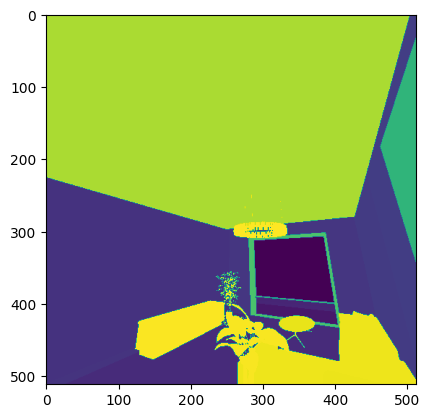

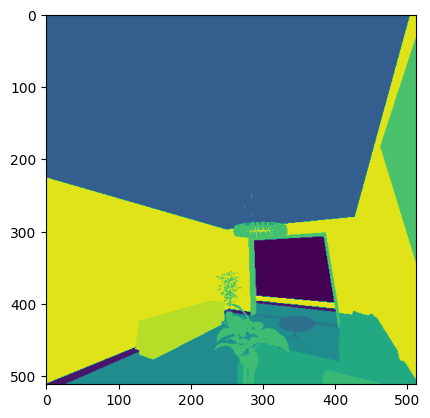

In [7]:
key = exist_keys[0]
with env.begin() as txn:
    inst_key = f"{key}_instance".encode("ascii")
    inst = txn.get(inst_key)
    inst = np.frombuffer(zlib.decompress(inst), dtype=np.uint16).reshape(512, 512)
    plt.imshow(inst)
    plt.show()
    
    sem_key = f"{key}_sem".encode("ascii")
    sem = txn.get(sem_key)
    sem = np.frombuffer(zlib.decompress(sem), dtype=np.uint16).reshape(512, 512)
    plt.imshow(sem)